## Primilinaries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import umap
import json

from sklearn.metrics import pairwise_distances
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
# All gesture ids
GESTURES = [
  '00-gamma-ut',
  '01-are',
  '02-bmi',
  '03-cfaut',
  '04-dsolre',
  '05-elami',
  '06-ffaut',
  '07-gsolreut',
  '08-alamire',
  '09-bmifa',
  '10-csolfaut',
  '11-dlasolre',
  '12-elami',
  '13-ffaut',
  '14-gsolreut',
  '15-alamire',
  '16-bmifa',
  '17-cesolla',
  '18-delasol',
  '19-ela',
  'none'
]

# Hand landmarks
WRIST = 0
THUMB_CMC = 1
THUMB_MCP = 2
THUMB_IP = 3
THUMB_TIP = 4
INDEX_FINGER_MCP = 5
INDEX_FINGER_PIP = 6
INDEX_FINGER_DIP = 7
INDEX_FINGER_TIP = 8
MIDDLE_FINGER_MCP = 9
MIDDLE_FINGER_PIP = 10
MIDDLE_FINGER_DIP = 11
MIDDLE_FINGER_TIP = 12
RING_FINGER_MCP = 13
RING_FINGER_PIP = 14
RING_FINGER_DIP = 15
RING_FINGER_TIP = 16
PINKY_MCP = 17
PINKY_PIP = 18
PINKY_DIP = 19
PINKY_TIP = 20

LANDMARKS = ["wrist", "thumb_cmc", "thumb_mcp", "thumb_ip", "thumb_tip", "index_finger_mcp", "index_finger_pip", "index_finger_dip", "index_finger_tip", "middle_finger_mcp", "middle_finger_pip", "middle_finger_dip", "middle_finger_tip", "ring_finger_mcp", "ring_finger_pip", "ring_finger_dip", "ring_finger_tip", "pinky_mcp", "pinky_pip", "pinky_dip", "pinky_tip"]

# Connections that form the hand
HAND_PALM_CONNECTIONS = ((0, 1), (0, 5), (9, 13), (13, 17), (5, 9), (0, 17))
HAND_THUMB_CONNECTIONS = ((1, 2), (2, 3), (3, 4))
HAND_INDEX_FINGER_CONNECTIONS = ((5, 6), (6, 7), (7, 8))
HAND_MIDDLE_FINGER_CONNECTIONS = ((9, 10), (10, 11), (11, 12))
HAND_RING_FINGER_CONNECTIONS = ((13, 14), (14, 15), (15, 16))
HAND_PINKY_FINGER_CONNECTIONS = ((17, 18), (18, 19), (19, 20))
HAND_CONNECTIONS = frozenset().union(*[
    HAND_PALM_CONNECTIONS, HAND_THUMB_CONNECTIONS,
    HAND_INDEX_FINGER_CONNECTIONS, HAND_MIDDLE_FINGER_CONNECTIONS,
    HAND_RING_FINGER_CONNECTIONS, HAND_PINKY_FINGER_CONNECTIONS
])

In [3]:
def draw_hand(coordinates, scale=1, ax=None):
  if ax is not None: plt.sca(ax)
  x, y, z = coordinates.T
  for a, b in HAND_CONNECTIONS:
    plt.plot([x[a], x[b]], [y[a], y[b]], 'k-', alpha=.2, lw=scale * 10)

  s = 1 - (z - z.min()) / (z.max() - z.min())
  plt.scatter(x, y, s=s * 25 * scale, c='k')

  plt.axis('off');
  plt.gca().invert_xaxis()
  plt.gca().invert_yaxis()


## Load data

In [4]:
# Load dataframe and shuffle it
df = pd.read_csv('data.csv').sample(frac=1, random_state=1)
y = df['gesture'].values
X = df.drop(columns=['gesture', 'gesture_name']).values

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Number of features N
num_feats = len(LANDMARKS)

# Indices of the upper triangle of a square N x N matrix
triu_idx = np.triu_indices(num_feats, k=1)

# Feature names of the pairwise distance features 
dist_feat_names = np.array(triu_idx).T

def to_dist_features(coords):
  pdist = pairwise_distances(coords.reshape(num_feats, 3))
  return pdist[triu_idx]

In [7]:
# Convert to distance features (upper triangle of the pairwise distances matrix)
D_train = np.array([to_dist_features(coords) for coords in X_train])
D_test = np.array([to_dist_features(coords) for coords in X_test])

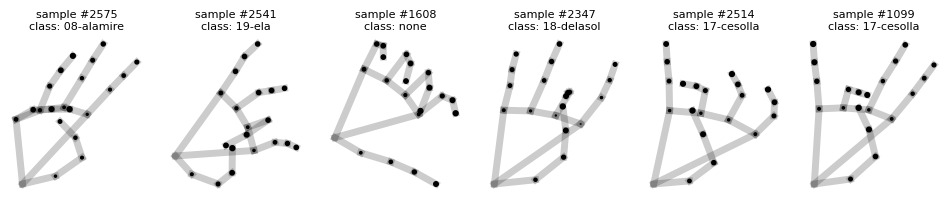

In [8]:
# Draw some hands
N = 6
np.random.seed(2)
rows = np.random.randint(0, len(X), N)
fig, axes = plt.subplots(1, N, figsize=(2 * N, 2))
for i, row in enumerate(rows):
  coords = X[row, :].reshape(21, 3)
  draw_hand(coords, scale=.5, ax=axes[i])
  plt.title(f'sample #{row}\nclass: {df.iloc[row, -1]}', fontsize=8)

## Attempt 1: distance

In [9]:
idx = 2
print(idx, 'class idx', y[idx], GESTURES[y_train[idx]])
input = X_train[idx, :]
points = input.reshape(21, 3)
dists = np.linalg.norm(points[THUMB_TIP] - points, axis=1)
closest = np.argsort(dists)[1]
closest

2 class idx 19 18-delasol


10

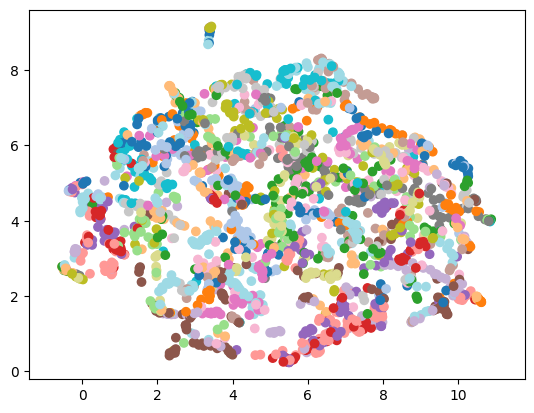

In [10]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_train)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=y_train, cmap='tab20')
plt.gca().set_aspect('equal', 'datalim')

## Attempt 2: pairwise distances

In [11]:
# Number of features N
num_feats = len(LANDMARKS)

# Indices of the upper triangle of a square N x N matrix
triu_idx = np.triu_indices(num_feats, k=1)

# Feature names of the pairwise distance features 
dist_feat_names = np.array(triu_idx).T

def to_dist_features(coords):
  pdist = pairwise_distances(coords.reshape(num_feats, 3))
  return pdist[triu_idx]

In [12]:
# Convert to distance features (upper triangle of the pairwise distances matrix)
D_train = np.array([to_dist_features(coords) for coords in X_train])
D_test = np.array([to_dist_features(coords) for coords in X_test])

This looks more informative:

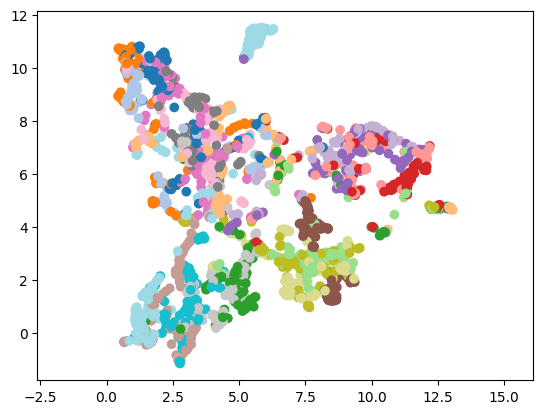

In [13]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(D_train)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=y_train, cmap='tab20')
plt.gca().set_aspect('equal', 'datalim')

In [14]:
clf = MLPClassifier(hidden_layer_sizes=(32,), random_state=1, max_iter=1000).fit(D_train, y_train)
y_pred = clf.predict(D_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94        25
           1       0.91      0.88      0.89        33
           2       0.97      0.85      0.91        34
           3       0.72      0.95      0.82        19
           4       0.86      0.80      0.83        15
           5       0.90      0.85      0.88        33
           6       1.00      0.70      0.82        30
           7       0.64      0.90      0.75        20
           8       0.85      0.88      0.87        26
           9       0.89      0.97      0.93        33
          10       0.93      0.93      0.93        27
          11       0.86      0.86      0.86        29
          12       0.82      0.87      0.84        31
          13       0.78      0.72      0.75        29
          14       0.89      0.83      0.86        29
          15       0.80      0.95      0.87        21
          16       0.91      0.83      0.87        35
          17       0.87    

/Users/bas/repos/projects/manual-music-models/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [15]:
y_pred = clf.predict(D_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94        25
           1       0.91      0.88      0.89        33
           2       0.97      0.85      0.91        34
           3       0.72      0.95      0.82        19
           4       0.86      0.80      0.83        15
           5       0.90      0.85      0.88        33
           6       1.00      0.70      0.82        30
           7       0.64      0.90      0.75        20
           8       0.85      0.88      0.87        26
           9       0.89      0.97      0.93        33
          10       0.93      0.93      0.93        27
          11       0.86      0.86      0.86        29
          12       0.82      0.87      0.84        31
          13       0.78      0.72      0.75        29
          14       0.89      0.83      0.86        29
          15       0.80      0.95      0.87        21
          16       0.91      0.83      0.87        35
          17       0.87    

<Axes: >

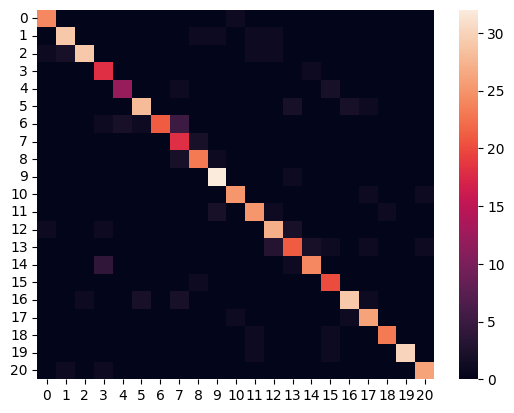

In [16]:
sns.heatmap(confusion_matrix(y_test, y_pred))

### Feature importance

<BarContainer object of 210 artists>

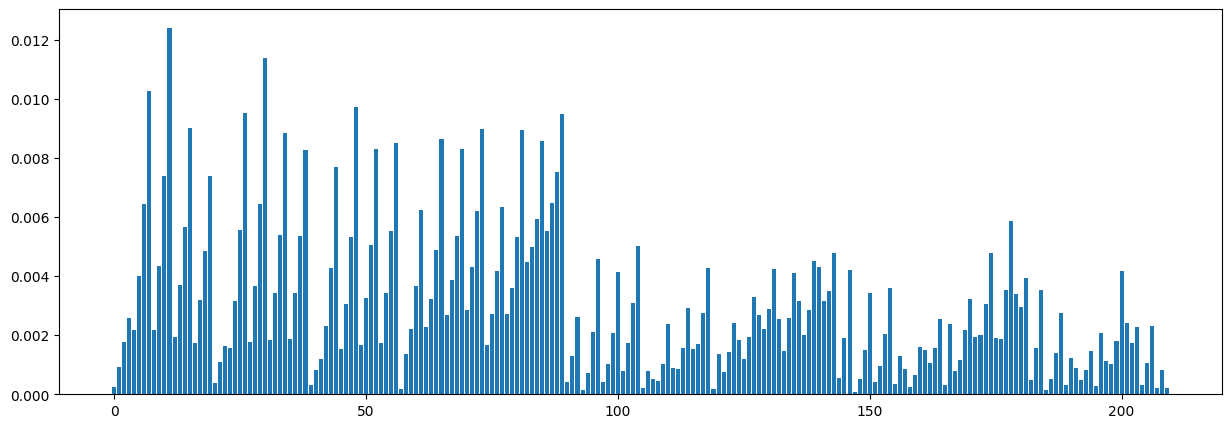

In [17]:
M = 210
plt.figure(figsize=(15, 5))
plt.bar(np.arange(M), height=np.var(D_train[:, :M], axis=0))
# plt.xticks(range(M), [f"{a},{b}" for a, b in dist_feat_names[:M]]);

Most variance is in the finger tips:

Text(0, 0.5, 'total variance')

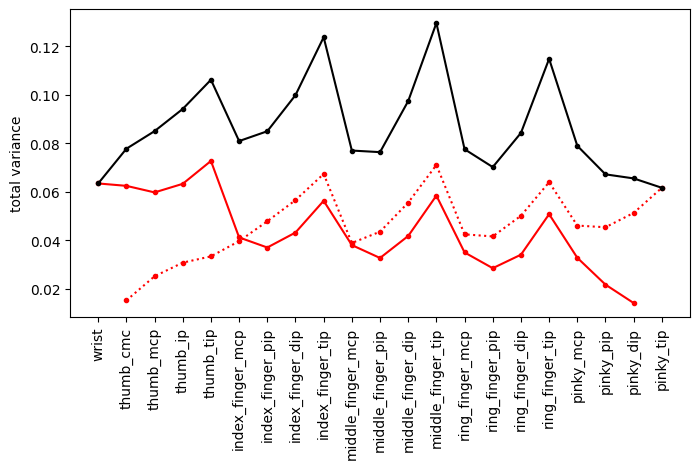

In [18]:
vardf = pd.DataFrame(D_train.std(axis=0), columns=['std'])
vardf['landmark1'] = dist_feat_names[:, 0]
vardf['landmark2'] = dist_feat_names[:, 1]

mean_var_landmark1 = vardf.groupby('landmark1').mean()['std']
mean_var_landmark2 = vardf.groupby('landmark2').mean()['std']
total_variance = pd.concat([mean_var_landmark1, mean_var_landmark2], axis=1).sum(axis=1)

plt.figure(figsize=(8, 4))
plt.plot(mean_var_landmark1, 'r.-')
plt.plot(mean_var_landmark2, 'r.:')
plt.plot(total_variance, 'k.-')
plt.xticks(range(len(LANDMARKS)), LANDMARKS, rotation=90);
plt.ylabel('total variance')

In [19]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif

In [20]:
sel = SelectKBest(f_classif, k=28)
D_train_new = sel.fit_transform(D_train, y_train)
D_test_new = sel.transform(D_test)

names = sel.get_feature_names_out(dist_feat_names)
# [f'{LANDMARKS[a]} - {LANDMARKS[b]}' for a, b in names]
# names

In [21]:
clf = MLPClassifier(hidden_layer_sizes=(28,), random_state=1, max_iter=1000).fit(D_train_new, y_train)
y_pred = clf.predict(D_test_new)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85        25
           1       0.87      0.82      0.84        33
           2       0.94      0.85      0.89        34
           3       0.78      0.95      0.86        19
           4       0.86      0.80      0.83        15
           5       0.81      0.76      0.78        33
           6       1.00      0.63      0.78        30
           7       0.62      0.80      0.70        20
           8       0.77      0.77      0.77        26
           9       0.82      0.97      0.89        33
          10       0.93      0.96      0.95        27
          11       0.85      0.97      0.90        29
          12       0.85      0.71      0.77        31
          13       0.72      0.72      0.72        29
          14       0.83      0.86      0.85        29
          15       0.67      0.76      0.71        21
          16       0.83      0.83      0.83        35
          17       0.86    

/Users/bas/repos/projects/manual-music-models/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [22]:
from copy import deepcopy

def prune_clf(clf, q=0.1):
  clf_pruned = deepcopy(clf)
  for i in range(len(clf_pruned.coefs_)):
    clf_pruned.coefs_[i] = prune_weights(clf_pruned.coefs_[i], q=q)
  return clf_pruned

def prune_weights(weights, q=0.1):
  tol = np.quantile(np.abs(weights), q)
  return np.where(np.abs(weights) < tol, 0, weights)

clf_pruned = prune_clf(clf, q=.2)
y_pred = clf_pruned.predict(D_test_new)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84        25
           1       0.87      0.82      0.84        33
           2       0.94      0.85      0.89        34
           3       0.78      0.95      0.86        19
           4       0.86      0.80      0.83        15
           5       0.81      0.76      0.78        33
           6       1.00      0.63      0.78        30
           7       0.62      0.80      0.70        20
           8       0.77      0.77      0.77        26
           9       0.82      0.97      0.89        33
          10       0.93      0.96      0.95        27
          11       0.85      0.97      0.90        29
          12       0.83      0.65      0.73        31
          13       0.70      0.72      0.71        29
          14       0.83      0.86      0.85        29
          15       0.67      0.76      0.71        21
          16       0.83      0.83      0.83        35
          17       0.86    

## Attempt 3: TF MLP

In [23]:
# https://github.com/tensorflow/tfjs/issues/8328
# https://blog.tensorflow.org/2024/03/whats-new-in-tensorflow-216.html
import tensorflow as tf 
import numpy as np 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense 
import tensorflowjs as tfjs

In [24]:
# Feature selection
sel = SelectKBest(f_classif, k=64)
D_train_new = sel.fit_transform(D_train, y_train)
D_test_new = sel.transform(D_test)
names = sel.get_feature_names_out(dist_feat_names)

In [25]:
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=21)
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=21)
n_samples = y_train_onehot.shape[0]

model = Sequential([ 
    Dense(64, activation='relu'),
    Dense(21, activation='softmax')
]) 

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy']) 

history = model.fit(
  D_train_new, 
  y_train_onehot, 
  epochs=2000,  
  batch_size=64,
  verbose=1,  
  validation_split=0.2
)

Epoch 1/2000
30/30 [==============================] - 1s 5ms/step - loss: 3.0374 - accuracy: 0.0721 - val_loss: 3.0162 - val_accuracy: 0.0968
Epoch 2/2000
30/30 [==============================] - 0s 1ms/step - loss: 2.9967 - accuracy: 0.1544 - val_loss: 2.9822 - val_accuracy: 0.1656
Epoch 3/2000
30/30 [==============================] - 0s 1ms/step - loss: 2.9581 - accuracy: 0.1829 - val_loss: 2.9454 - val_accuracy: 0.1505
Epoch 4/2000
30/30 [==============================] - 0s 1ms/step - loss: 2.9141 - accuracy: 0.1953 - val_loss: 2.8971 - val_accuracy: 0.1656
Epoch 5/2000
30/30 [==============================] - 0s 1ms/step - loss: 2.8625 - accuracy: 0.2130 - val_loss: 2.8391 - val_accuracy: 0.2022
Epoch 6/2000
30/30 [==============================] - 0s 1ms/step - loss: 2.8017 - accuracy: 0.2093 - val_loss: 2.7751 - val_accuracy: 0.2065
Epoch 7/2000
30/30 [==============================] - 0s 1ms/step - loss: 2.7339 - accuracy: 0.2765 - val_loss: 2.7005 - val_accuracy: 0.2624
Epoch 

KeyboardInterrupt: 

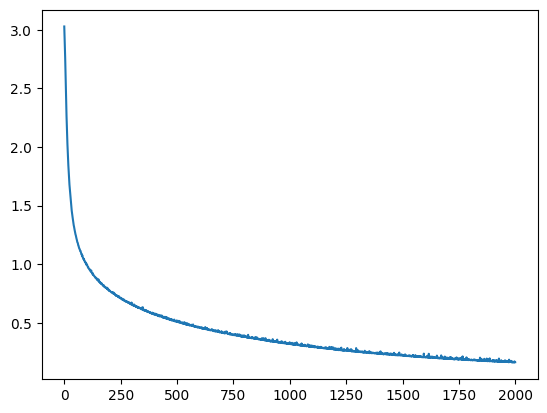

In [51]:
plt.plot(history.history['loss'])

In [56]:
pred = model.predict(D_test_new)
y_pred = np.argmax(pred, axis=1)
print(classification_report(y_test, y_pred))

19/19 [==============================] - 0s 439us/step
              precision    recall  f1-score   support

           0       0.86      0.96      0.91        25
           1       0.92      0.73      0.81        33
           2       0.88      0.88      0.88        34
           3       0.95      1.00      0.97        19
           4       0.86      0.80      0.83        15
           5       0.93      0.85      0.89        33
           6       1.00      0.77      0.87        30
           7       0.74      0.85      0.79        20
           8       0.81      1.00      0.90        26
           9       1.00      0.97      0.98        33
          10       0.96      1.00      0.98        27
          11       0.88      0.97      0.92        29
          12       0.96      0.84      0.90        31
          13       0.80      0.83      0.81        29
          14       0.90      0.97      0.93        29
          15       0.79      0.90      0.84        21
          16       0.94   

In [54]:
# Export the model
dir = 'exported-models/model-5'
tfjs.converters.save_keras_model(model, dir)
with open(f'{dir}/selected-features.json', 'w') as handle:
  json.dump(names.tolist(), handle)

/Users/bas/repos/projects/manual-music-analysis/env/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
